## ***SENTIMENT ANALYSIS***

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [64]:
#Importing all the important libraries
from google.colab import files
import pandas as pd
import io
import matplotlib.pyplot as plt
import string
from sklearn import metrics

#Tokenization Libraries
import nltk
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import WordPunctTokenizer
from nltk.tokenize import TweetTokenizer
import re
nltk.download('punkt')

#Stemmer Libraries
from nltk.stem.porter import PorterStemmer 

#Lemmatizer Libraries
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

#Stop Words
nltk.download('stopwords')
from nltk.corpus import stopwords as nltk_stopwords

#Ngrams
from nltk.util import ngrams

#Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#Modeling
#Logistic
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
#Multinomial
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
#XGB
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import linear_model
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
#uploading the train dataset
train = files.upload()

Saving train.csv to train.csv


In [3]:
#uploading the test dataset
test = files.upload()

Saving test.csv to test.csv


# Exploratory Data Analysis

In [4]:
#Converting both train and test
train = pd.read_csv(io.BytesIO(train['train.csv'])) 
print(train)
test = pd.read_csv(io.BytesIO(test['test.csv'])) 
print(test)

        Id                                               text  Target
0        1  @USAirways  ! THE WORST in customer service. @...      -1
1        2  @united call wait times are over 20 minutes an...      -1
2        3  @JetBlue what's up with the random delay on fl...      -1
3        4  @AmericanAir Good morning!  Wondering why my p...       0
4        5  @united UA 746. Pacific Rim and Date Night cut...      -1
...    ...                                                ...     ...
7315  7316                            @AmericanAir followback       0
7316  7317  @united thanks for the help. Wish the phone re...       1
7317  7318  @usairways the. Worst. Ever. #dca #customerser...      -1
7318  7319  @nrhodes85: look! Another apology. DO NOT FLY ...      -1
7319  7320  @united you are by far the worst airline. 4 pl...      -1

[7320 rows x 3 columns]
         id                                               text
0      7322  @AmericanAir In car gng to DFW. Pulled over 1h...
1      73

In [5]:
#Analysing the train dataset
print(train["Target"].value_counts()) # We can see that majority (60+%) of the tweets are negative
print(train['Target'].value_counts(normalize=True))

-1    4566
 0    1536
 1    1218
Name: Target, dtype: int64
-1    0.623770
 0    0.209836
 1    0.166393
Name: Target, dtype: float64


In [6]:
train["Id"].nunique() #There are a total of 7320 unique tweeet ids

7320

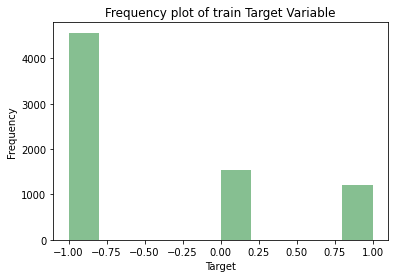

In [7]:
plt.hist(train["Target"],color='#86bf91')
plt.gca().set(title= "Frequency plot of train Target Variable", xlabel = "Target",ylabel = "Frequency")
plt.show()

# Preprocessing Data

***NLTK Regex Tokenizer***

In [8]:
def reg_ex(data):
  reg_e = []
  for i in range(len(train)):
    tokenizer = RegexpTokenizer('\w+\.?\w?|\$[\d\.]+|\S+')
    reg_e.append(tokenizer.tokenize(train["text"][i]))
  return reg_e

In [9]:
  #Train
  reg_o = reg_ex(train)
  print(reg_o) # in this we can see that it has kept the @,#together, however, it has made can't as (can and t), this wil give a wrong pic
  #Test
  reg_o_test = reg_ex(test)

[['@USAirways', '!', 'THE', 'WORST', 'in', 'customer', 'service.', '@USAirways', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#poorcustomerservice', '#usairwaysfflyer'], ['@united', 'call', 'wait', 'times', 'are', 'over', '20', 'minutes', 'and', 'airport', 'wait', 'times', 'are', 'longer'], ['@JetBlue', 'what', "'s", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'being', 'a', 'false', 'alarm', '?'], ['@AmericanAir', 'Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre', '-TSA', 'check', 'was', 'not', 'on', 'my', 'boarding', 'pass', 'this', 'morning', '??'], ['@united', 'UA', '746.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably.'], ['@SouthwestAir', 'it', 'was', 'not', '-', 'still', 'don', "'t", 'know', 'where', 'skis', 'are', 'and', 'cannot', 'get', 'a', 'call', 'back', 'from', 'bag', 'svc', 'at', 'airpor

***Word Tokenizer***

In [10]:
def wrd_p(data):
  wrd_te = []
  for i in range(len(data)):
    wrd_te.append(nltk.word_tokenize(data["text"][i]))
  return wrd_te

In [11]:
#Train
wrd_o = wrd_p(train)
print(wrd_o) #we can observe that it seperates hashtags, while analyzing tweets this will be a disadvantage. This also doesn't help with the above apstrophe issue.
#test
wrd_o_test = wrd_p(test)

[['@', 'USAirways', '!', 'THE', 'WORST', 'in', 'customer', 'service', '.', '@', 'USAirways', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#', 'poorcustomerservice', '#', 'usairwaysfflyer'], ['@', 'united', 'call', 'wait', 'times', 'are', 'over', '20', 'minutes', 'and', 'airport', 'wait', 'times', 'are', 'longer'], ['@', 'JetBlue', 'what', "'s", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'being', 'a', 'false', 'alarm', '?'], ['@', 'AmericanAir', 'Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre-TSA', 'check', 'was', 'not', 'on', 'my', 'boarding', 'pass', 'this', 'morning', '?', '?'], ['@', 'united', 'UA', '746', '.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out', '.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably', '.'], ['@', 'SouthwestAir', 'it', 'was', 'not', '-', 'still', 'do', "n't", 'know', 'where', 'skis', 'are', 'and', 'can', 'not', 'get', 

***Tweet Tokenizer***


In [12]:
#Removing the handles as we do not care for which airlines it has been written for sentiment classification
def twe_p(data):
  twe_e = []
  for i in range(len(train)):
    tokenizer=TweetTokenizer(strip_handles= True, reduce_len=True)
    twe_e.append(tokenizer.tokenize(data["text"][i]))
  return twe_e

In [13]:
twe_o = twe_p(train)
twe_o_test = twe_p(test)

In [14]:
print(twe_o) #This has solved the issue of apostrophe.

[['!', 'THE', 'WORST', 'in', 'customer', 'service', '.', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#poorcustomerservice', '#usairwaysfflyer'], ['call', 'wait', 'times', 'are', 'over', '20', 'minutes', 'and', 'airport', 'wait', 'times', 'are', 'longer'], ["what's", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'being', 'a', 'false', 'alarm', '?'], ['Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre-TSA', 'check', 'was', 'not', 'on', 'my', 'boarding', 'pass', 'this', 'morning', '?', '?'], ['UA', '746', '.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out', '.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably', '.'], ['it', 'was', 'not', '-', 'still', "don't", 'know', 'where', 'skis', 'are', 'and', 'cannot', 'get', 'a', 'call', 'back', 'from', 'bag', 'svc', 'at', 'airport', '(', 'left', 'several', 'msgs', ')'], ['See', '?', 'We', 'were', 'told', 'repeatedl

***Custom Regular Expression Word Tokenization***

In [15]:
# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)
regexes=(r"(?:@[\w_]+)",
# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",
#Keep words with apostrophes, hyphens and underscores together(can't, don't etc)
r"(?:[a-z][a-z’'\-_]+[a-z])",
# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",
# Everything else that's not whitespace
r"(?:\S)"
)
big_regex="|".join(regexes)

my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)

def my_extensible_tokenize(data):
  cust_e = []
  for i in range(len(data)):
    cust_e.append(my_extensible_tokenizer.findall(data["text"][i]))
  return cust_e

In [16]:
cust_o = my_extensible_tokenize(train)
print(cust_o)
cust_o_test = my_extensible_tokenize(test)

[['@USAirways', '!', 'THE', 'WORST', 'in', 'customer', 'service', '.', '@USAirways', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#poorcustomerservice', '#usairwaysfflyer'], ['@united', 'call', 'wait', 'times', 'are', 'over', '20', 'minutes', 'and', 'airport', 'wait', 'times', 'are', 'longer'], ['@JetBlue', "what's", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'being', 'a', 'false', 'alarm', '?'], ['@AmericanAir', 'Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre-TSA', 'check', 'was', 'not', 'on', 'my', 'boarding', 'pass', 'this', 'morning', '?', '?'], ['@united', 'UA', '746', '.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out', '.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably', '.'], ['@SouthwestAir', 'it', 'was', 'not', '-', 'still', "don't", 'know', 'where', 'skis', 'are', 'and', 'cannot', 'get', 'a', 'call', 'back', 'from', 'bag', 'svc', 'at',

***Porter Stemming*** - To remove unnecessary words like ing, ed etc.

In [17]:
def stemmer_tokenizer_cust_o(data):
  stem_cust_e=[]
  for i in range(len(data)):
    stemmer = PorterStemmer()
    stem_cust_e.append([stemmer.stem(token) for token in data[i]])
  return stem_cust_e

In [18]:
stem_cust_o=stemmer_tokenizer_cust_o(cust_o)
stem_cust_o_test=stemmer_tokenizer_cust_o(cust_o_test)

**We can see that in case of stemmer, a lot of words don't make sense, like, service becomes servic and so on. So, we will use Lemmatization instead as it uses only dictionary words.**

**Lemmatization with POS tag info**

In [19]:
def get_part_of_speech_tags(token):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tag = nltk.pos_tag([token])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)
def wrd_lem(data):
  lem_wr=[]
  for i in range(len(data)):
    lemmatizer = WordNetLemmatizer()
    lem_wr.append(([lemmatizer.lemmatize(token,get_part_of_speech_tags(token)) for token in data[i]]))
  return lem_wr

**Lemmatization with Customer reg tokenization**

In [20]:
lem_wr_o=wrd_lem(cust_o)
print(lem_wr_o)
lem_wr_o_test=wrd_lem(cust_o_test)

[['@USAirways', '!', 'THE', 'WORST', 'in', 'customer', 'service', '.', '@USAirways', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#poorcustomerservice', '#usairwaysfflyer'], ['@united', 'call', 'wait', 'time', 'be', 'over', '20', 'minute', 'and', 'airport', 'wait', 'time', 'be', 'longer'], ['@JetBlue', "what's", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'be', 'a', 'false', 'alarm', '?'], ['@AmericanAir', 'Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre-TSA', 'check', 'be', 'not', 'on', 'my', 'boarding', 'pas', 'this', 'morning', '?', '?'], ['@united', 'UA', '746', '.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out', '.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably', '.'], ['@SouthwestAir', 'it', 'be', 'not', '-', 'still', "don't", 'know', 'where', 'ski', 'be', 'and', 'cannot', 'get', 'a', 'call', 'back', 'from', 'bag', 'svc', 'at', 'airport', '

**Lemmatization with Customer Tweet Tokenization**

In [21]:
lem_tw_o=wrd_lem(twe_o)
print(lem_tw_o)
lem_tw_o_test=wrd_lem(twe_o_test)

[['!', 'THE', 'WORST', 'in', 'customer', 'service', '.', '!', 'Calling', 'for', 'over', 'a', 'month', 'to', 'book', 'a', 'flight', '!', '#poorcustomerservice', '#usairwaysfflyer'], ['call', 'wait', 'time', 'be', 'over', '20', 'minute', 'and', 'airport', 'wait', 'time', 'be', 'longer'], ["what's", 'up', 'with', 'the', 'random', 'delay', 'on', 'flight', '1729', '?', 'Any', 'chance', 'of', 'it', 'be', 'a', 'false', 'alarm', '?'], ['Good', 'morning', '!', 'Wondering', 'why', 'my', 'pre-TSA', 'check', 'be', 'not', 'on', 'my', 'boarding', 'pas', 'this', 'morning', '?', '?'], ['UA', '746', '.', 'Pacific', 'Rim', 'and', 'Date', 'Night', 'cut', 'out', '.', 'Not', 'constantly', 'or', 'randomly', ',', 'but', 'one', 'spot', ',', 'repeatably', '.'], ['it', 'be', 'not', '-', 'still', "don't", 'know', 'where', 'ski', 'be', 'and', 'cannot', 'get', 'a', 'call', 'back', 'from', 'bag', 'svc', 'at', 'airport', '(', 'left', 'several', 'msg', ')'], ['See', '?', 'We', 'be', 'told', 'repeatedly', 'that', 'the

**Case fold and Customized stop words and punctuations**



In [22]:
#Not removing the stop words that are negative and might help in analysis
def stp_wrd(data):
  stp_1_l =[]
  stp_1=[]
  puncs_1 = []
  puncs = set(string.punctuation) - {"'"}
  ", ".join(puncs)
  stop = set(nltk_stopwords.words('english')) - {"not", "don't", "wasn't","didn't","won't","hasn't","haven't","shouldn't","aren't","needn't","doesn't","wouldn't","weren't"}
  ", ".join(stop)
  stp_1 = []
  for i in range(len(data)):
    stp_1.append(([token for token in data[i] if not token in stop]))
    stp_1_l.append([x.lower() for x in stp_1[i]])
    puncs_1.append(([token for token in stp_1_l[i] if not token in puncs]))
  return puncs_1

**Case fold, punctuation and Customized stop words for customized reg exp**

In [23]:
stp_1_o = stp_wrd(lem_wr_o)
print(stp_1_o)
stp_1_o_test = stp_wrd(lem_wr_o_test)

[['@usairways', 'the', 'worst', 'customer', 'service', '@usairways', 'calling', 'month', 'book', 'flight', '#poorcustomerservice', '#usairwaysfflyer'], ['@united', 'call', 'wait', 'time', '20', 'minute', 'airport', 'wait', 'time', 'longer'], ['@jetblue', "what's", 'random', 'delay', 'flight', '1729', 'any', 'chance', 'false', 'alarm'], ['@americanair', 'good', 'morning', 'wondering', 'pre-tsa', 'check', 'not', 'boarding', 'pas', 'morning'], ['@united', 'ua', '746', 'pacific', 'rim', 'date', 'night', 'cut', 'not', 'constantly', 'randomly', 'one', 'spot', 'repeatably'], ['@southwestair', 'not', 'still', "don't", 'know', 'ski', 'cannot', 'get', 'call', 'back', 'bag', 'svc', 'airport', 'left', 'several', 'msg'], ['@united', 'see', 'we', 'told', 'repeatedly', 'pilot', 'late', 'flight', 'kept', 'get', 'late', 'flightr', 'after', 'board', 'defibrillator', 'issue'], ['@southwestair', 'flt', '463', 'san', 'jose', 'ca', 'gt', 'denver', 'co', 'delayed', '2', 'hr', 'easily', 'best', 'flight', 'tou

**Case fold, punctuation and Customized stop words for Tweet Tokenization**

In [24]:
stp_2_o = stp_wrd(lem_tw_o)
print(stp_2_o)
stp_2_o_test = stp_wrd(lem_tw_o_test)

[['the', 'worst', 'customer', 'service', 'calling', 'month', 'book', 'flight', '#poorcustomerservice', '#usairwaysfflyer'], ['call', 'wait', 'time', '20', 'minute', 'airport', 'wait', 'time', 'longer'], ["what's", 'random', 'delay', 'flight', '1729', 'any', 'chance', 'false', 'alarm'], ['good', 'morning', 'wondering', 'pre-tsa', 'check', 'not', 'boarding', 'pas', 'morning'], ['ua', '746', 'pacific', 'rim', 'date', 'night', 'cut', 'not', 'constantly', 'randomly', 'one', 'spot', 'repeatably'], ['not', 'still', "don't", 'know', 'ski', 'cannot', 'get', 'call', 'back', 'bag', 'svc', 'airport', 'left', 'several', 'msg'], ['see', 'we', 'told', 'repeatedly', 'pilot', 'late', 'flight', 'kept', 'get', 'late', 'flightr', 'after', 'board', 'defibrillator', 'issue'], ['flt', '463', 'san', 'jose', 'ca', '->', 'denver', 'co', 'delayed', '2', 'hr', 'easily', 'best', 'flight', 'touchdown', 'year', 'fly', 'keep'], ['yo', 'give', 'plane', 'back', "they're", 'mad', 'threaten', 'take', 'away', 'companion',

***Vectorization***

In [25]:
# Converting the list to Dataframes
def dafr(data):
  data=pd.DataFrame(" ".join(x) for x in data)
  return data

In [26]:
#Customized data
stp_1_o=dafr(stp_1_o)
stp_1_o_test=dafr(stp_1_o_test)
lem_wr_o=dafr(lem_wr_o)
lem_wr_o_test=dafr(lem_wr_o_test)

In [27]:
#Tweet Data
stp_2_o=dafr(stp_2_o)
stp_2_o_test=dafr(stp_2_o_test)

In [28]:
#Count Vectorizer
def vec(train,test):
  vectorizer=CountVectorizer(max_features=6000,stop_words= None,analyzer='word')
  X_train = vectorizer.fit_transform(train[0])
  X_test = vectorizer.transform(test[0])
  return X_train,X_test

In [29]:
#Tfidf Vectorizer
def vec2(train,test):
  tfidf = TfidfVectorizer(stop_words=None ,max_features=6000, max_df=0.95)
  X_train = tfidf.fit_transform(train[0])
  X_test = tfidf.transform(test[0])
  return X_train,X_test

In [30]:
# #Customized data
stp_1_o,stp_1_o_test=vec(stp_1_o,stp_1_o_test)
stp_2_o,stp_2_o_test=vec(stp_2_o,stp_2_o_test)
#Lematized o/p
lem_wr_o_1,lem_wr_o_test=vec(lem_wr_o,lem_wr_o_test)

In [ ]:
# #Customized data
stp_1_o_2,stp_1_o_test_2=vec2(stp_1_o,stp_1_o_test)
stp_2_o_2,stp_2_o_test_2=vec2(stp_2_o,stp_2_o_test)

In [ ]:
# Customized data
stp_1_o2=vec2(stp_1_o)
stp_1_o_test2=vec2(stp_1_o_test)
#Twitter Data
stp_2_o2=vec(stp_2_o)
stp_2_o_test2=vec2(stp_2_o_test)

# MODELING - Logistic, Multinomial, XGB

**Modeling - I ran many models with different parameters and the best parameters were as below. We can see that the model after lemmatization(Without removing stop words and punctuation) has the highest Cross validation score. This means that maybe the stop words and punctuations are adding some value in identifying the sentiment of the text for the given dataset**

**Running the model using lemmatized output**

In [ ]:
#Modeling
models = [
    MultinomialNB(),
    XGBClassifier(max_depth=3,gamma=1),
    linear_model.LogisticRegression(C=0.5)
]
# 15 Cross-validation
CV = 15
cv_data = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, lem_wr_o_1,train["Target"], scoring='f1_macro', cv=15)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))  
cv_data = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])

In [69]:
mean_accuracy = cv_data.groupby('model_name').f1.mean()
std_accuracy = cv_data.groupby('model_name').f1.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                           
LogisticRegression       0.740229            0.024864
MultinomialNB            0.680647            0.026888
XGBClassifier            0.610454            0.030666

In [70]:
model = linear_model.LogisticRegression(C=0.5)
model.fit(lem_wr_o_1,train["Target"])
test["Predic"] = model.predict(lem_wr_o_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [71]:
final = test[['id','text']]
final['Target'] = test['Predic']
# final
final.to_csv("Test_ss.csv",index = False)

***Running the model after stop words***

In [72]:
#Modeling
models = [
    MultinomialNB(),
    XGBClassifier(max_depth=3,gamma=1),
    linear_model.LogisticRegression(C=0.5)
]
# 15 Cross-validation
CV = 15
cv_data = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, stp_1_o,train["Target"], scoring='f1_macro', cv=15)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))    
cv_data = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'f1'])

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [73]:
mean_accuracy = cv_data.groupby('model_name').f1.mean()
std_accuracy = cv_data.groupby('model_name').f1.std()
acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                           
LogisticRegression       0.722571            0.019513
MultinomialNB            0.674864            0.022999
XGBClassifier            0.563681            0.029338

**On twitter tokenization**

In [74]:
#Modeling
models = [
    MultinomialNB(),
    XGBClassifier(max_depth=3,gamma=1),
    linear_model.LogisticRegression(C=0.5)
]
# 15 Cross-validation
CV = 15
cv_data = pd.DataFrame(index=range(CV * len(models)))
Values = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, stp_2_o,train["Target"], scoring='f1_macro', cv=15)
  for fold_idx, accuracy in enumerate(accuracies):
    Values.append((model_name, fold_idx, accuracy))   
cv_data = pd.DataFrame(Values, columns=['model_name', 'fold_idx', 'f1'])

In [75]:
mean_accuracy = cv_data.groupby('model_name').f1.mean()
std_accuracy = cv_data.groupby('model_name').f1.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1, 
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

Mean Accuracy  Standard deviation
model_name                                           
LogisticRegression       0.718848            0.018281
MultinomialNB            0.674479            0.021099
XGBClassifier            0.563576            0.023598

**GRID SEARCH ON LOGISTIC REGRESSION**

In [66]:
param_grid = {'C': [0.001, 0.01, 0.1,0.5,0.45,0.8,1,10]}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=15)
grid.fit(lem_wr_o_1, train["Target"])
print(grid.best_score_)
print(grid.best_estimator_)
best_model_logistic  = grid.best_estimator_

0.8027322404371585
LogisticRegression(C=0.45, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [63]:
best_model.fit(lem_wr_o_1,train["Target"])
final = test[['id','text']]
final['Target'] = best_model.predict(lem_wr_o_test)

## ***BEST MODEL - FINAL MODEL FUNCTION:***

*   Customer Reg Tokenization
*   Lemmatization with POS tagging
*   Count Vectorizer
*   Grid Search Logistic Regression





**CUSTOMER REG TOKENIZATION**

In [73]:
# Keep usernames together (any token starting with @, followed by A-Z, a-z, 0-9)
regexes=(r"(?:@[\w_]+)",
# Keep hashtags together (any token starting with #, followed by A-Z, a-z, 0-9, _, or -)
r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",
#Keep words with apostrophes, hyphens and underscores together(can't, don't etc)
r"(?:[a-z][a-z’'\-_]+[a-z])",
# Keep all other sequences of A-Z, a-z, 0-9, _ together
r"(?:[\w_]+)",
# Everything else that's not whitespace
r"(?:\S)"
)
big_regex="|".join(regexes)

my_extensible_tokenizer = re.compile(big_regex, re.VERBOSE | re.I | re.UNICODE)

def my_extensible_tokenize(data):
  cust_e = []
  for i in range(len(data)):
    cust_e.append(my_extensible_tokenizer.findall(data["text"][i]))
  return cust_e

***Lemmatization with POS Tagging***

In [74]:
def get_part_of_speech_tags(token):
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}
    tag = nltk.pos_tag([token])[0][1][0].upper()
    return tag_dict.get(tag, wordnet.NOUN)
def wrd_lem(data):
  lem_wr=[]
  for i in range(len(data)):
    lemmatizer = WordNetLemmatizer()
    lem_wr.append(([lemmatizer.lemmatize(token,get_part_of_speech_tags(token)) for token in data[i]]))
  return lem_wr

**Count Vectorizer**

In [75]:
def dafr(data):
  data=pd.DataFrame(" ".join(x) for x in data)
  return data
def vec(train,test):
  vectorizer=CountVectorizer(max_features=6000,stop_words= None,analyzer='word')
  X_train = vectorizer.fit_transform(train[0])
  X_test = vectorizer.transform(test[0])
  return X_train,X_test

**Logistic Regression**

In [76]:
def log_model(train,target,test):
  model = LogisticRegression(C=0.45, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
  model.fit(train,target)
  return model.predict(test)

## ***Final Function containing all the functions***

In [77]:
def final_model(data_tr,data_te):
  #Train tokenization
  tokenize_data_train= my_extensible_tokenize(data_tr)
  #Test Tokenization
  tokenize_data_test= my_extensible_tokenize(data_te)
  #Train lemmatization
  lemma_data_train = wrd_lem(tokenize_data_train)
  #Test lemmatization
  lemma_data_test = wrd_lem(tokenize_data_test)
  # Train dataframe
  train = dafr(lemma_data_train)
  #Test dataframe
  test = dafr(lemma_data_test)
  #Train, Test vector 
  vector_train,vector_test = vec(train,test)
  #Logistic
  Predictions=log_model(vector_train,data_tr["Target"],vector_test)
  return Predictions

In [80]:
Predictions = final_model(train,test)

## **----------------------------------------------THE END----------------------------------------------------**